In [1]:
from graphfla.analysis import *
from graphfla.problems import RoughMountFuji, NK, NumberPartitioning
from graphfla.landscape import Landscape
import pandas as pd


In [3]:
landscapes = [
    ("Whitlock2000", "boolean", 32, ['hairy', 'ebony-stripe', 'claret', 'black', 'plexus-speck'], "fitness"),
    ("Wu2016", "protein", 160000, "sequence", "Imputed fitness"),
    ("Weinreich2006Tan2011", "boolean", 32, ['g2405a', 'A42G', 'E104K', 'M182T', 'G238S'], "fitness (MIC)"),
    ("Soo2021", "dna", 65536, "sequence", "Log2 fold-change (30C)"),
    ("Rotrattanadumrong2022", "dna", 65536, "sequence", "FL_1"),
    ("Poelwijk2019", "boolean", 8192, [f"loci_{i + 2}" for i in range(13)], "combined"),
    ("PhoQ", "protein", 140517, [f"loci_{i + 1}" for i in range(4)], "Fitness"),
    ("Phillips2023", "boolean", 65536, "variant", "MA90_log10Kd"),
    ("Phillips2021_CR6261", "boolean", 1917, [f"pos{i + 1}" for i in range(11)], "h9_mean"),
    ("Phillips2021_CR9114", "boolean", 65536, [f"pos{i + 1}" for i in range(16)], "h1_mean"),
    ("Papkou2023", "dna", 135178, [f"p{i}" for i in range(9)], "fitness"),
    ("Palmer2015", "boolean", 64, ['C-35T', 'P21L', 'A26T', 'L28R', 'G30W', 'I94L'], "Log[IC75 of E. coli DHFR alleles against trimethoprim]"),
    ("OMaille2008", "boolean", 64, ['I372V', 'S402T', 'L406Y', 'T438I', 'L439I', 'I516V'], "sum(I:J)"),
    ("Moulana2022", "boolean", 32768, [f"loci_{i + 1}" for i in range(15)], "Mean fluorescence expression_a"),
    ("Mira2015", "boolean", 16, ['M69L', 'E104K', 'G238S', 'N276D'], "#Log[ZTP]"),
    ("Meini2015", "boolean", 16, ['G262S', 'L250S', 'V112A', 'N70S'], "Log[Metallo-beta-lactamase MIC against cephalexin]"),
    ("Malcolm1990", "boolean", 8, ['T40S', 'I55V', 'S91T'], "Avian lysozyme thermostability"),
    ("Lunzer2005", "boolean", 64, ['R236D', '?289?', '?290?', 'V296A', 'Y337G', 'R341S'], "Log[E. coli IMDH mutant relative growth rates]"),
    ("Lozovsky2009Jiang2013", "boolean", 16, ['N51I', 'C59R', 'S108N', 'I164L'], "Log[PYR IC50 of P. falciparum DHFR alleles assayed in E. coli]"),
    ("Lite2020", "protein", 7882, [f"loci_{i + 1}" for i in range(3)], "W_ParE3"),
    ("Kuo2020", "rna", 197890, [f"loci_{i + 1}" for i in range(9)], "mean"),
    ("Khan2011Flynn2013", "boolean", 64, ['rbs', 'topA', 'spoA', 'glnUS', 'pykF'], "#Log[E. coli relative fitness in DM25]"),
    ("Johnston2024", "protein", 160000, "AAs", "fitness"),
    ("Hall2010", "boolean", 64, ['ade', 'his', 'leu', 'met', 'trp', 'ura'], "#Log[Haploid S. cerevisiae mutant growth rate]"),
    ("Domingo2018", "rna", 4176, ['loci_1', 'loci_2', 'loci_6', 'loci_27', 'loci_43','loci_46', 'loci_66', 'loci_69', 'loci_70', 'loci_71'], "fitness"),
    ("deVisser2009", "boolean", 32, ['crn', 'oli', 'leu', 'pyr', 'arg'], "Log[Relative colony growth rate in Aspergillus niger]"),
    ("daSilva2010", "boolean", 32, ['N3H', 'S4R', 'P5R', 'G6E', 'E7K'], "Log[HIV replicative capacity on CCR5+ cells]"),
    ("Chou2011", "boolean", 16, ['fghA', 'pntAB', 'gshA', 'GB'], "Log[Relative fitness among Methylobacterium extorquens mutants]"),
    ("Bridgham2009", "boolean", 16, ['X', 'Y', 'Z', 'W'], "Mammalian glucocorticoid receptor cortisol sensitivity"),
    ("Bank2016", "boolean", 64, ['F583H', 'W585L', 'S586T', 'A587P', 'N588A', 'M589A'], "Log[S. cerevisiae HSP90 mutant growth rates]")
]

landscapes_dict = {
    item[0]: {
        "type": item[1],
        "size": item[2],
        "X": item[3],
        "f": item[4]
    }
    for item in landscapes
}

In [6]:
import glob
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

folder_path = '/Users/arwen/Downloads/graphfla25/GraphFLA/data/combinatorially_complete/tf_binding'
txt_files = glob.glob(f'{folder_path}/*.txt')

logger = []
for file_path in txt_files:
    df = pd.read_csv(file_path, sep="\t")
    X = df["8-mer"]
    f = df["E-score"]

    landscape = Landscape(type="dna")
    landscape.build_from_data(
        X, f, 
        calculate_basins=True, 
        calculate_distance=True, 
        calculate_paths=True, 
        calculate_neighbor_fit=True,
        verbose=False,
    )

    X = np.vstack(landscape.configs.values)
    y = landscape.graph.vs["fitness"]
    
    encoder = OneHotEncoder(sparse_output=False)
    X = encoder.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    print(landscape)
    print(f"R^2 Score: {r2:.4f}")
        
    logger.append((
        landscape.n_configs,
        landscape.n_vars,
        landscape.n_edges,
        landscape.n_lo,
        fdc(landscape),
        ffi(landscape),
        basin_fit_corr(landscape)["greedy"],
        basin_fit_corr(landscape)["accessible"],
        neighbor_fit_corr(landscape)["correlation"],
        lo_ratio(landscape),
        autocorrelation(landscape, walk_length=landscape.n_vars, walk_times=1000)["mean"],
        r_s_ratio(landscape),
        gradient_intensity(landscape),
        calculate_evol_enhance(landscape)["ee_proportion"],
        classify_epistasis(landscape, approximate=True, sample_cut_prob=0.5),
        # global_idiosyncratic_index(landscape)["global_index"],
        diminishing_returns_index(landscape),
        increasing_costs_index(landscape),
        global_optima_accessibility(landscape),
        neutrality(landscape),  
        r2,      
    ))


df_log = pd.DataFrame(logger, columns=[
    "n_configs",
    "n_vars",
    "n_edges",
    "n_lo",
    "fdc",
    "ffi",
    "basin_fit_corr_greedy",
    "basin_fit_corr_accessible",
    "neighbor_fit_corr",
    "lo_ratio",
    "autocorrelation_mean",
    "r_s_ratio",
    "gradient_intensity",
    "evol_enhance_ee_proportion",
    "epistasis_classification",
    # "global_idiosyncratic_index_global_index",
    "diminishing_returns_index",
    "increasing_costs_index",
    "global_optima_accessibility",
    "neutrality",
    "r2"
])

basin_fit_corr_greedy, basin_fit_corr_accessible = [], []
for corr in df_log["basin_fit_corr_greedy"].to_list():
    basin_fit_corr_greedy.append(corr[0])

for corr in df_log["basin_fit_corr_accessible"].to_list():
    basin_fit_corr_accessible.append(corr[0])

df_log["basin_fit_corr_greedy"] = basin_fit_corr_greedy
df_log["basin_fit_corr_accessible"] = basin_fit_corr_accessible
df_log = df_log.drop(columns=["epistasis_classification"]).join(df_log["epistasis_classification"].apply(pd.Series))

df_log.to_csv("landscape_all_tf.csv", index=False)

Landscape with 8 variables, 32896 configurations, 340347 connections, and 294 local optima.
R^2 Score: 0.6189
Landscape with 8 variables, 32896 configurations, 340348 connections, and 274 local optima.
R^2 Score: 0.7130
Landscape with 8 variables, 32896 configurations, 340345 connections, and 318 local optima.
R^2 Score: 0.7069
Landscape with 8 variables, 32896 configurations, 340339 connections, and 1197 local optima.
R^2 Score: 0.2887
Landscape with 8 variables, 32896 configurations, 340341 connections, and 274 local optima.
R^2 Score: 0.7592
Landscape with 8 variables, 32896 configurations, 340342 connections, and 216 local optima.
R^2 Score: 0.7843
Landscape with 8 variables, 32896 configurations, 340342 connections, and 1201 local optima.
R^2 Score: 0.2055
Landscape with 8 variables, 32896 configurations, 340343 connections, and 154 local optima.
R^2 Score: 0.8071
Landscape with 8 variables, 32896 configurations, 340343 connections, and 322 local optima.
R^2 Score: 0.6897
Landscap

In [29]:
df_log.columns

Index(['n_configs', 'n_vars', 'n_edges', 'n_lo', 'fdc', 'ffi',
       'basin_fit_corr_greedy', 'basin_fit_corr_accessible',
       'neighbor_fit_corr', 'lo_ratio', 'autocorrelation_mean', 'r_s_ratio',
       'gradient_intensity', 'evol_enhance_ee_proportion',
       'diminishing_returns_index', 'increasing_costs_index',
       'global_optima_accessibility', 'neutrality', 'r2',
       'magnitude epistasis', 'sign epistasis', 'reciprocal sign epistasis',
       'positive epistasis', 'negative epistasis'],
      dtype='object')

In [32]:
import umap
reducer = umap.UMAP(n_neighbors=10,   # Controls how local/global the embedding is
                   min_dist=0.5,      # Minimum distance between points in the projection
                   n_components=2,    # Number of dimensions to reduce to
                   metric='euclidean',
                   random_state=42)

X = df_log.iloc[:, 3:].drop(columns=["r2", "n_lo", "negative epistasis"])
embedding = reducer.fit_transform(X)

df_embed = pd.DataFrame(embedding, columns=["cmp1", "cmp2"])


/Users/arwen/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arwen/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


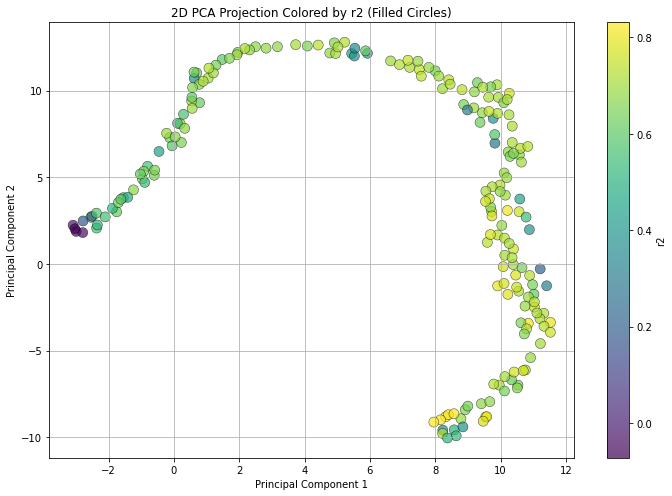

In [33]:
df_embed = pd.DataFrame(embedding, columns=["cmp1", "cmp2"])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_embed["cmp1"], df_embed["cmp2"],
                      c=df_log['r2'], cmap='viridis', s=100, alpha=0.7,
                      edgecolors='black', linewidth=0.5, marker='o')  # 'o' is the filled circle marker
plt.colorbar(scatter, label='r2')
plt.title('2D PCA Projection Colored by r2 (Filled Circles)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
df_log.corr()["r2"]

n_configs                           NaN
n_vars                              NaN
n_edges                       -0.101940
n_lo                          -0.958186
fdc                           -0.172854
ffi                           -0.683390
basin_fit_corr_greedy          0.086291
basin_fit_corr_accessible      0.846837
neighbor_fit_corr              0.973347
lo_ratio                      -0.958186
autocorrelation_mean           0.906423
r_s_ratio                     -0.662406
gradient_intensity             0.386117
evol_enhance_ee_proportion     0.889408
diminishing_returns_index      0.610705
increasing_costs_index        -0.262961
global_optima_accessibility    0.673091
neutrality                    -0.267566
r2                             1.000000
magnitude epistasis            0.827603
sign epistasis                 0.065648
reciprocal sign epistasis     -0.897488
positive epistasis            -0.789996
negative epistasis             0.789996
Name: r2, dtype: float64

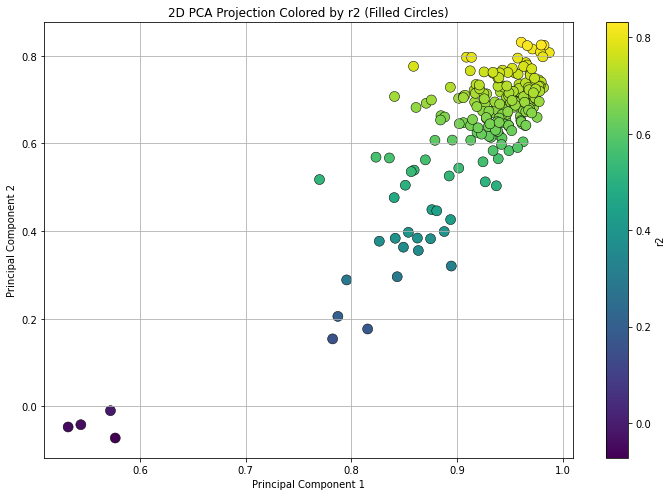

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_log["basin_fit_corr_accessible"], df_log["r2"],
                      c=df_log['r2'], cmap='viridis', s=100, alpha=1,
                      edgecolors='black', linewidth=0.5, marker='o')  # 'o' is the filled circle marker
plt.colorbar(scatter, label='r2')
plt.title('2D PCA Projection Colored by r2 (Filled Circles)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
classify_epistasis(landscape)

{'magnitude epistasis': 0.4341494070714247,
 'sign epistasis': 0.35084684089094564,
 'reciprocal sign epistasis': 0.21500375203762967,
 'positive epistasis': 0.782947622087839,
 'negative epistasis': 0.21705237791216103}

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

logger = []

for name, info in landscapes_dict.items():

    print(f"\nLoading {name} landscape...")
        
    type = info["type"]
    X_cols = info["X"]
    f_col = info["f"]

    if name == "Phillips2023":
        df = pd.read_csv(f"/Users/arwen/Downloads/graphfla25/GraphFLA/data/combinatorially_complete/{name}.csv", dtype={"variant": str})
    else:
        df = pd.read_csv(f"/Users/arwen/Downloads/graphfla25/GraphFLA/data/combinatorially_complete/{name}.csv")
    X = df[X_cols]
    f = df[f_col]

    landscape = Landscape(type=type)
    landscape.build_from_data(
        X, f, 
        calculate_basins=True, 
        calculate_distance=True, 
        calculate_paths=True, 
        calculate_neighbor_fit=True,
        verbose=False,
    )
    print(landscape)

    approximate = True if landscape.n_configs > 100000 else False

    X = np.vstack(landscape.configs.values)
    y = landscape.graph.vs["fitness"]
    
    # Apply one-hot encoding if the type is not boolean
    if type != "boolean":
        encoder = OneHotEncoder(sparse_output=False)
        X = encoder.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - R^2 Score: {r2:.4f}")
        
    logger.append((
        name,
        landscape.n_configs,
        landscape.n_vars,
        landscape.n_edges,
        landscape.n_lo,
        fdc(landscape),
        ffi(landscape),
        basin_fit_corr(landscape)["greedy"],
        basin_fit_corr(landscape)["accessible"],
        neighbor_fit_corr(landscape)["correlation"],
        lo_ratio(landscape),
        autocorrelation(landscape, walk_length=landscape.n_vars, walk_times=1000)["mean"],
        r_s_ratio(landscape),
        gradient_intensity(landscape),
        calculate_evol_enhance(landscape)["ee_proportion"],
        # classify_epistasis(landscape, approximate=approximate),
        # global_idiosyncratic_index(landscape)["global_index"],
        diminishing_returns_index(landscape),
        increasing_costs_index(landscape),
        global_optima_accessibility(landscape),
        neutrality(landscape),  
        r2,      
    ))

In [ ]:
df_log = pd.DataFrame(logger, columns=[
    "Landscape",
    "n_configs",
    "n_vars",
    "n_edges",
    "n_lo",
    "fdc",
    "ffi",
    "basin_fit_corr_greedy",
    "basin_fit_corr_accessible",
    "neighbor_fit_corr",
    "lo_ratio",
    "autocorrelation_mean",
    "r_s_ratio",
    "gradient_intensity",
    "evol_enhance_ee_proportion",
    # "epistasis_classification",
    # "global_idiosyncratic_index_global_index",
    "diminishing_returns_index",
    "increasing_costs_index",
    "global_optima_accessibility",
    "neutrality",
    "r2"
])

basin_fit_corr_greedy, basin_fit_corr_accessible = [], []
for corr in df_log["basin_fit_corr_greedy"].to_list():
    basin_fit_corr_greedy.append(corr[0])

for corr in df_log["basin_fit_corr_accessible"].to_list():
    basin_fit_corr_accessible.append(corr[0])

df_log["basin_fit_corr_greedy"] = basin_fit_corr_greedy
df_log["basin_fit_corr_accessible"] = basin_fit_corr_accessible

df_log.to_csv("landscape_all_tf.csv", index=False)

In [ ]:
df_log.to_csv("landscape_all_tf.csv", index=False)

In [7]:
import pandas as pd
df = pd.read_csv("landscape_all.csv")
df.corr(numeric_only=True, method="spearman")["r2"]

n_configs                      0.414661
n_vars                         0.459485
n_edges                        0.399243
n_lo                           0.213538
fdc                            0.136819
ffi                           -0.132309
basin_fit_corr_greedy         -0.307313
basin_fit_corr_accessible     -0.094096
neighbor_fit_corr              0.747720
lo_ratio                      -0.657233
autocorrelation_mean           0.573749
r_s_ratio                      0.078087
gradient_intensity            -0.406007
evol_enhance_ee_proportion     0.447658
diminishing_returns_index     -0.061179
increasing_costs_index         0.030478
global_optima_accessibility    0.097480
neutrality                     0.241106
r2                             1.000000
Name: r2, dtype: float64

In [11]:
df = df[df["r2"] > 0]

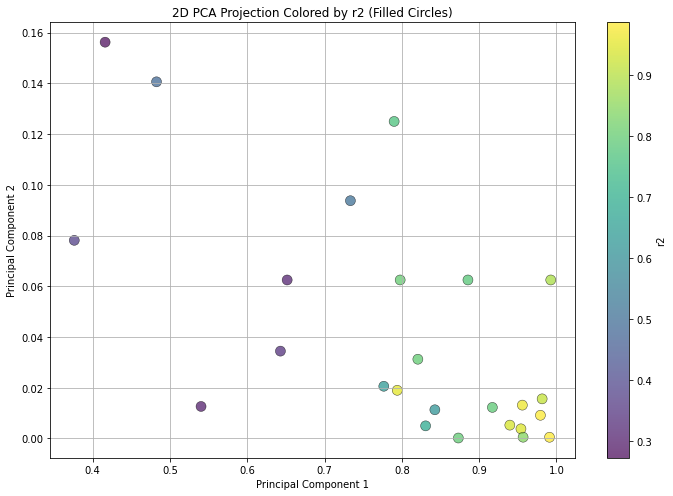

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
scatter = plt.scatter(df["neighbor_fit_corr"], df["lo_ratio"],
                      c=df['r2'], cmap='viridis', s=100, alpha=0.7,
                      edgecolors='black', linewidth=0.5, marker='o')  # 'o' is the filled circle marker
plt.colorbar(scatter, label='r2')
plt.title('2D PCA Projection Colored by r2 (Filled Circles)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
df_log.to_csv("df_log.csv", index=False)

In [22]:
X

0                       0
1                       1
2                      10
3                      11
4                     100
               ...       
65531    1111111111111011
65532    1111111111111100
65533    1111111111111101
65534    1111111111111110
65535    1111111111111111
Name: variant, Length: 65536, dtype: int64

In [23]:
df

,Unnamed: 0,variant,MA90_log10Kd,SI06_log10Kd,G189E_log10Kd,MA90_stelog10Kd,SI06_stelog10Kd,G189E_stelog10Kd,Expression_log10Kd,Expression_stelog10Kd,...,G189E_12_deltaKd,MA90_13_deltaKd,SI06_13_deltaKd,G189E_13_deltaKd,MA90_14_deltaKd,SI06_14_deltaKd,G189E_14_deltaKd,MA90_15_deltaKd,SI06_15_deltaKd,G189E_15_deltaKd
0,0,0,-8.551773,-6.000000,-6.000000,0.060948,0.000000,0.000000,0.944386,0.015674,...,0.0,0.002697,0.000000,0.000000,0.228845,0.000000,0.000000,-0.030909,0.000000,0.000000
1,1,1,-8.582682,-6.000000,-6.000000,0.049298,0.000000,0.000000,0.974086,0.012051,...,0.0,0.039659,0.000000,0.000000,0.099925,0.000000,0.000000,NaN,NaN,NaN
2,2,10,-8.322928,-6.000000,-6.000000,0.017317,0.000000,0.000000,1.004697,0.019708,...,0.0,-0.011433,0.000000,0.000000,NaN,NaN,NaN,-0.159828,0.000000,0.000000
3,3,11,-8.482757,-6.000000,-6.000000,0.028426,0.000000,0.000000,1.028047,0.009873,...,0.0,-0.116215,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100,-8.549076,-6.000000,-6.000000,0.002980,0.000000,0.000000,1.005798,0.033826,...,0.0,NaN,NaN,NaN,0.214715,0.000000,0.000000,0.006053,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,65531,1111111111111011,-10.101516,-9.360610,-9.787656,0.002209,0.104371,0.011345,0.994944,0.029407,...,NaN,-0.001111,0.015153,0.038694,NaN,NaN,NaN,NaN,NaN,NaN
65532,65532,1111111111111100,-10.061378,-9.016422,-9.706458,0.031420,0.072008,0.018619,0.955257,0.002315,...,NaN,NaN,NaN,NaN,0.099298,0.221751,0.071527,-0.071300,-0.246364,-0.023470
65533,65533,1111111111111101,-10.132678,-9.262786,-9.729929,0.017694,0.035337,0.019264,0.980961,0.017057,...,NaN,NaN,NaN,NaN,0.030051,-0.082671,-0.019034,NaN,NaN,NaN
65534,65534,1111111111111110,-9.962080,-8.794671,-9.634932,0.007632,0.005798,0.054936,1.032449,0.022401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.140548,-0.550786,-0.114031


In [182]:
df["DimSum fitness (30ºC)"]

KeyError: 'DimSum fitness (30ºC)'

In [177]:
df

,Genotype (N2-N5/N18-N21),Log2 fold-change (30ºC),Padj (30ºC),DimSum fitness (30ºC),DimSum sigma (30ºC),Log2 fold-change (37ºC),Padj (37ºC),DimSum fitness (37ºC),DimSum sigma (37ºC),Kan+30C_R1,...,Kan+37C_R3,Kan+37C_R4,Kan+37C_R5,Kan+37C_R6,Kan-37C_R1,Kan-37C_R2,Kan-37C_R3,Kan-37C_R4,Kan-37C_R5,Kan-37C_R6
0,AAAAAAAA,-0.743101,1.084125e-01,-2.264254,0.169602,0.096300,8.533249e-01,-0.664203,0.144396,18,...,58,32,15,32,72,56,20,26,22,22
1,AAAAAAAC,-2.948730,1.960000e-07,-3.109374,0.219045,-3.065422,1.550000e-07,-2.355683,0.164139,1,...,7,6,7,3,51,49,220,41,35,17
2,AAAAAAAG,-0.945745,6.617035e-03,-2.306624,0.098011,-0.393651,3.092667e-01,-1.026433,0.121124,20,...,27,33,36,29,63,62,28,43,37,43
3,AAAAAAAT,0.117694,6.436205e-01,-1.913913,0.091363,-0.006330,9.828174e-01,-1.013130,0.121953,87,...,51,55,42,48,75,59,47,70,53,64
4,AAAAAACA,1.054723,8.100688e-03,-0.674549,0.092418,0.382334,3.835759e-01,-0.406911,0.110646,48,...,11,37,78,60,54,20,18,56,28,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,TTTTTTGT,-2.422551,1.281740e-04,-2.653261,0.182741,-2.765115,6.100000e-05,-2.126561,0.239899,1,...,0,11,8,3,43,42,27,22,31,21
65532,TTTTTTTA,-0.979970,1.381616e-01,-1.941225,0.223963,-0.246519,7.225230e-01,-1.054105,0.161116,0,...,9,27,13,12,30,15,16,15,20,28
65533,TTTTTTTC,-4.660955,1.803307e-03,-3.606666,0.527594,-5.418273,5.875120e-04,-1.981382,1.120572,0,...,0,2,0,0,12,11,1,7,50,23
65534,TTTTTTTG,-0.438055,4.877792e-01,-1.603748,0.082249,0.190153,7.876362e-01,-0.496510,0.116565,38,...,16,17,30,44,18,29,41,35,26,44


In [147]:
df = pd.read_csv("/Users/arwen/Downloads/combinatorially_complete/Bank2016.csv")
df

,F583H,W585L,S586T,A587P,N588A,M589A,Log[S. cerevisiae HSP90 mutant growth rates],Unnamed: 7
0,0,0,0,0,0,0,0.000000,0.000000e+00
1,0,0,0,1,0,0,-0.014725,4.170000e-06
2,0,0,1,0,0,0,0.003710,5.250000e-07
3,0,0,1,1,0,0,0.001972,1.500000e-08
4,1,0,0,0,0,0,-0.066347,2.690000e-05
...,...,...,...,...,...,...,...,...
59,0,1,1,1,1,1,0.010618,4.790000e-07
60,1,1,0,0,1,1,-0.552735,2.566240e-04
61,1,1,0,1,1,1,-0.416085,1.024921e-03
62,1,1,1,0,1,1,-0.319178,3.680000e-07


In [ ]:
[f"loci_{i + 1}" for i in range(10)]

['loci_1',
 'loci_2',
 'loci_3',
 'loci_4',
 'loci_5',
 'loci_6',
 'loci_7',
 'loci_8',
 'loci_9']

In [148]:
df.columns

Index(['F583H', 'W585L', 'S586T', 'A587P', 'N588A', 'M589A',
       'Log[S. cerevisiae HSP90 mutant growth rates]', 'Unnamed: 7'],
      dtype='object')

In [63]:
df["h1_mean"].isnull().sum()    

442

In [ ]:
df = pd.read_csv("/Users/arwen/Downloads/graphfla25/GraphFLA/data/combinatorially_complete/Wu2016.csv")
# X = df.iloc[:, :6]
# f = df["Fitness"]

# landscape = Landscape(type="protein")
# landscape.build_from_data(X, f)

In [ ]:
from graphfla.analysis import *
from graphfla.problems import RoughMountFuji, NK, NumberPartitioning
from graphfla.landscape import Landscape
import pandas as pd

logger = []
for alpha in [0.2, 0.3]:
    print(alpha)
    landscape_model = NumberPartitioning(n=10, alpha=alpha, seed=42)
    df = landscape_model.get_data()

    X = df["config"].apply(pd.Series)
    f = df["fitness"]

    landscape = Landscape(type="boolean", maximize=True,)
    landscape.build_from_data(X, f, calculate_paths=True, verbose=False)
    logger.append((
        alpha,
        fdc(landscape),
        # ffi(landscape),
        basin_fit_corr(landscape)["greedy"],
        basin_fit_corr(landscape)["accessible"],
        neighbor_fit_corr(landscape)["correlation"],
        lo_ratio(landscape),
        autocorrelation(landscape, walk_length=7, walk_times=1000)["mean"],
        # r_s_ratio(landscape),
        # gradient_intensity(landscape),
        calculate_evol_enhance(landscape)["ee_proportion"],
        classify_epistasis(landscape),
        global_idiosyncratic_index(landscape)["global_index"],
        diminishing_returns_index(landscape),
        increasing_costs_index(landscape),
        global_optima_accessibility(landscape),
        neutrality(landscape),        
))
    

columns = [
    "k",
    "fdc",
    # "ffi",
    "basin_fit_corr_greedy",
    "basin_fit_corr_accessible",
    "neighbor_fit_corr",
    "lo_ratio",
    "autocorrelation",
    # "r_s_ratio",
    # "gradient_intensity",
    "ee_proportion",
    "epistasis",
    "global_idiosyncratic_index",
    "diminishing_returns_index",
    "increasing_costs_index",
    "global_optima_accessibility",
    "neutrality",
]




In [ ]:
# import igraph as ig

# def hamming_distance(s1, s2):
#     """
#     Calculate the Hamming distance between two binary strings of equal length.
#     """
#     if len(s1) != len(s2):
#         raise ValueError("Strings must be of the same length.")
#     return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# def build_hamming_graph(bin_strings):
#     """
#     Given a list of binary strings (all the same length),
#     construct an igraph where nodes are these strings, and
#     two nodes share an edge if their Hamming distance = 1.
#     """
#     n = len(bin_strings)
    
#     # Create a list of edges
#     edges = []
#     for i in range(n):
#         for j in range(i + 1, n):
#             if hamming_distance(bin_strings[i], bin_strings[j]) == 1:
#                 edges.append((i, j))
                
#     # Build the graph
#     g = ig.Graph(n, edges=edges, directed=False)
    
#     # Optionally, assign the string as a vertex attribute
#     g.vs["label"] = bin_strings
    
#     return g

# if __name__ == "__main__":
#     # Example usage
#     binary_list = ["00000", "00001", "11101", "11100", "01000"]
    
#     # Build the graph
#     graph = build_hamming_graph(binary_list)
    
#     # Print some information
#     print(graph)
#     print("Graph edges (each pair of node indices):", graph.get_edgelist())
    
#     # Print the corresponding binary strings for each node
#     for idx, label in enumerate(graph.vs["label"]):
#         print(f"Vertex {idx}: {label}")


In [ ]:
# from graphfla.problems import RoughMountFuji, NK
# import pandas as pd
# import time 
# logger = []
# for n in range(5, 20):
#     landscape_model = NK(n=n, k=4, seed=42)
#     df = landscape_model.get_data()

#     X = df["config"].apply(pd.Series)
#     f = df["fitness"]

#     bitstrings = X.astype(str).agg(''.join, axis=1).tolist()

#     start = time.time()
#     graph = build_hamming_graph(bitstrings)
#     end = time.time()
#     print(f"Dimension: {n}. Time taken to build Hamming graph:", end - start, len(X))

In [ ]:
# from graphfla.landscape import Landscape
# from graphfla.problems import RoughMountFuji, NK
# import pandas as pd
# import time
# logger = []

# for n in range(5, 17):
#     landscape_model = NK(n=n, k=4, seed=42)
#     df = landscape_model.get_data()

#     X = df["config"].apply(pd.Series)
#     f = df["fitness"]

#     start = time.time()
#     landscape = Landscape(type="boolean", maximize=True)
#     landscape.build_from_data(
#         X, f, 
#         data_types="boolean", 
#         calculate_paths=True, 
#         calculate_basins=True,
#         calculate_distance=True,
#         calculate_neighbor_fit=True,
#         impute=True, 
#         verbose=False
#     )
#     end = time.time()
#     logger.append((n, end - start))
#     print(f"\nDimension: {n + 1}")
#     # print(f"d={n}, Elapsed time for NK landscape: {end - start}", )

In [ ]:
# pd.DataFrame(logger, columns=["n", "time"]).to_csv("NK_landscape_poly.csv", index=False)

In [ ]:
# landscape_model = NK(n=21, k=4, seed=42)
# df = landscape_model.get_data()

# X = df["config"].apply(pd.Series)
# f = df["fitness"]


# bitstrings = X.astype(str).agg(''.join, axis=1).tolist()

# start = time.time()
# graph = build_hamming_graph(binary_list)
# end = time.time()
# print("Time taken to build Hamming graph:", end - start, len(X))